In [1]:
import numpy as np
from scipy.special import expit as sigmoid
from scipy.stats import bernoulli
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from scipy.stats import beta
import pandas as pd
%matplotlib inline

In [2]:
class DataModel:
    def __init__(self,mean_x,cov_x,w,b,epsilon_y):
        self.mean_x = mean_x
        self.cov_x = cov_x
        self.w = np.array(w).reshape((1,len(w)))
        self.b = np.array(b).reshape((1,len(w)+1))
        self.epsilon_y = epsilon_y
    
    def sample(self,samples):
         # Assume x drawn from a multivarate gaussain distribution
        self.x = np.random.multivariate_normal(self.mean_x,self.cov_x,size=samples)
        
        # Assume t is ~ bernoulli with p = sigmoid(w.x)
        z = np.dot(self.x,self.w.T)
        p = sigmoid(z)
        self.t = bernoulli.rvs(p)

        # Assume Y a linear function of (x,t) with guassian noise
        self.phi = np.hstack((self.x,self.t)) # augment x with the vector t
        self.phi1 = np.hstack((self.x,np.ones((len(self.x),1))))
        self.phi0 = np.hstack((self.x,np.zeros((len(self.x),1))))
        
        self.y = self._y(self.phi) # the actual distribution
        self.y1 = self._y(self.phi1) # what y would be if everyone were treated
        self.y0 = self._y(self.phi0) # what y would be if everyone recieved control
        return (self.x,self.t,self.phi,self.y)
        
    def _y(self,phi):
        y = np.dot(phi,self.b.T)
        noise = np.random.normal(loc=0,scale=self.epsilon_y,size=len(y)).reshape(y.shape)
        return y+noise
    
    def ate(self):
        return self.b[0,-1]
        
    def plot(self):
        # plot P(Y|do(t=1)) and P(Y|do(t=0)) 
        fig, ax = plt.subplots(2)
        sns.distplot(self.y1,ax=ax[0],label="Y1")
        sns.distplot(self.y0,ax=ax[0],label="Y0")
        ite = self.y1-self.y0
        sns.distplot(ite,ax=ax[1],color="red",label="ITE")
        ax[0].legend()
        ax[1].legend()
        ax[1].vlines(self.ate(),ymin=0,ymax=ax[1].get_ylim()[1])
        plt.show()

In [3]:
class Context:
    """class to store details about state of model used in simulation."""
    def __init__(self,num_features,aw,bw,ab,bb,cm,epsilon,samples=1000,simulations=1000,true_ate=1):
        self.num_features = num_features
        self.aw = aw
        self.bw = bw
        self.ab = ab
        self.bb = bb
        self.cm = cm
        self.epsilon = epsilon
        self.samples = samples
        self.simulations = simulations
        self.true_ate = true_ate
        self.params = [num_features,aw,bw,ab,bb,cm,epsilon,samples,simulations,true_ate]
    
        self.w = beta.rvs(aw, bw, size=num_features)
        self.b = np.append( beta.rvs(ab,bb,size=num_features),true_ate)
        self.x_mean = np.zeros(num_features)
        self.x_cov = cm*np.diag(np.ones(num_features))
        self.model = DataModel(self.x_mean,self.x_cov,self.w,self.b,epsilon)
        
        
    def run(self):
        model = self.model
        r = np.zeros((self.simulations,3))
        for s in range(self.simulations):
            model.sample(self.samples)
            ate_unadjusted = model.y[(model.t==1)].mean() - model.y[(model.t==0)].mean()
            ate_fit,scores,selected= lasso_then_ridge(model)
            lsq_fit = least_squares(model)
            r[s] = [lsq_fit,ate_fit,ate_unadjusted]
        rm = r.mean(axis=0)
        re = 3*r.std(axis=0)/np.sqrt(self.simulations)
        delta = (rm[1]-rm[0])/(re[1]+re[0])
        return delta,rm,re
    
    def __str__(self):
        return "{0}, ({1},{2}), ({3},{4}), {5}, {6}, {7}, {8}, {9}".format(self.num_features,self.aw,self.bw,self.ab,self.bb,self.cm,self.epsilon,self.samples,self.simulations,self.true_ate)

In [7]:
def lasso_then_ridge(model,ridge_alpha = [0,.001,.01,.1,1]):
    target,phi = model.y.reshape(len(model.y)),model.phi
        
    X_train,X_test,y_train,y_test = train_test_split(phi,target,test_size=.33)
    alphas,_,coefs = linear_model.lars_path(X_train,y_train,method="lasso")
    
    params = []
    scores = []
    best_score = float("inf")
    best_model = None
    best_selected = None
    for i in range(len(alphas)):  # at each value of alpha - extract the features that are non-zero
        c = coefs[:,i]
        selected = np.where(c>0)[0]
        if len(selected > 0):
            X = X_train[:,selected] # only use features selected by lasso
            for alpha in ridge_alpha:                    
                ridge = linear_model.Ridge(alpha=alpha,copy_X=True)
                ridge.fit(X,y_train)        
                y_pred = ridge.predict(X_test[:,selected])# score the model 
                score = mean_squared_error(y_test,y_pred)
                params.append((alphas[i],alpha))
                scores.append(score)
                if score < best_score:
                    best_score = score
                    best_model = ridge
                    best_selected = selected
    scores = sorted(list(zip(scores,params)),key = lambda x:x[0])
    
    y0_pred = best_model.predict(model.phi0[:,best_selected])
    y1_pred = best_model.predict(model.phi1[:,best_selected])
    ite_pred = y1_pred - y0_pred
    ate_pred = ite_pred.mean()
    return ate_pred,scores,best_selected
                    
def least_squares(model):
    lsq = linear_model.LinearRegression()
    lsq.fit(model.phi,model.y)
    y0_pred = lsq.predict(model.phi0)
    y1_pred = lsq.predict(model.phi1)
    ite_pred = y1_pred - y0_pred
    ate_pred = ite_pred.mean()
    return ate_pred
                        

## Can unregularized least-squares beat lasso+ridge for causal effect estimation?
Removing features (with lasso) reduces the variance but increases bias in a way that is not caputured by the cross-validation. (Because we can't cross-validate on how far off we are on the actual causal effect - only on how well we are predicting the target).

Given that, it seemed like there should be settings in which simple least-squares consistently beats lasso+ridge.

In the example below, many of the features have a strong link to treatment but a weak link to the target. This means they may be dropped insufficiently predictive but the total strength of the backdoor path, t<-x->y may still be moderate.

Experimentally it appears that there are situations in which this problem is real. 

In [8]:
s = Context(20,6,1,1,6,2,3)
delta,rm,re = s.run()

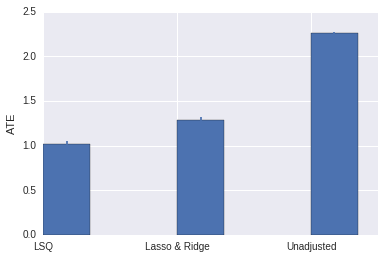

In [9]:
fig, ax = plt.subplots()
ind = np.arange(3)
width=.35
ax.bar(ind, rm,width = width,yerr = re)
ax.set_ylabel('ATE')
ax.set_xticks(ind)
ax.set_xticklabels(('LSQ', 'Lasso & Ridge', 'Unadjusted'))
plt.show()